This notebook loads our submission data and provides statistics and results

### Imports

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import gaussian_kde

In [44]:
unique_rules = train_df["rule"].unique().tolist()
len(unique_rules), unique_rules

(2,
 ['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.',
  'No legal advice: Do not offer or request legal advice.'])

### Load Data / Submissions

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
solution_df = pd.read_csv('data/solution.csv')

In [5]:
sub_paths = [f for f in os.listdir("submissions") if f.endswith(".csv")]

submissions = {}
for f in sub_paths:
    name = f.replace("submission_", "").replace(".csv", "")
    submissions[name] = pd.read_csv(os.path.join("submissions", f))

submissions.keys()

dict_keys(['Logistic', 'RandomForest', 'XGBoost', 'LightGBM', 'ensemble', 'mlp', 'mlp_all-MiniLM-L12-v2', 'mlp_all-mpnet-base-v2', 'mlp_sentence-transformers_all-roberta-large-v1', 'mlp_._e5-large-v2-triplet', 'mlp_paraphrase-multilingual-mpnet-base-v2'])

### Merge predictions with labels and metadata -> outputing metrics dataframe

In [28]:
rows = []

solution = solution_df[["row_id", "rule_violation"]]
test_meta = test_df.copy()

for name, df in submissions.items():

    m = (
        df.merge(solution, on="row_id", how="left")      
          .merge(test_meta, on="row_id", how="left")     
    )

    m["model_name"] = name

    rows.append(m)

all_models_df = pd.concat(rows, ignore_index=True)

all_models_df["rule_short"] = (
    all_models_df["rule"]
        .astype(str)
        .str.split(":")
        .str[0]
)

all_models_df.head()

,row_id,prediction,rule_violation,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,model_name,rule_short
0,2029,0.470909,1,Hi Ken l! /u/Whimsical_wispers told me he want...,No promotion of illegal activity: Do not encou...,IAmA,There are several web sites on internet that a...,Someone needs to rape that judge and see how w...,call whores watch for you herein http://onj.me...,52 http://MySexFind.com - find girl for sex no...,Logistic,No promotion of illegal activity
1,2030,0.350374,1,Doubt anyone will read this but anti depressan...,No medical advice: Do not offer or request spe...,science,Maybe he just has alzheimer's. It would explai...,Hmm well I WAS going to ask women of Reddit ho...,You could always just carry your kid and get t...,Maybe you should get started on the solution a...,Logistic,No medical advice
2,2031,0.448603,0,**[One of her best show](http://shortora.com/i...,"No Advertising: Spam, referral links, unsolici...",NSFW_GIF,Son Dakika Ek Kazanç Videolarımızı İzleyin :\n...,Try My New Game..! :)\nhttps://play.google.com...,**HD** Stream[English Tiwtch](http://www.zifoo...,/r/krat0m <-subscribe for free kilo of strong ...,Logistic,No Advertising
3,2032,0.339291,0,If he'd cheat on you he'll cheat on her. She's...,No spoilers: Do not reveal important details t...,relationships,And now Jessica is gone. They really need to ...,"Probably a meme at this point, particularly th...","hahah. Please, Barry changed his name to hide ...",I found the full video.\nThere were a few peop...,Logistic,No spoilers
4,2033,0.482490,1,I think I remember reading somewhere that tech...,No legal advice: Do not offer or request legal...,AskReddit,"I mean, even if they didn't have anything sign...","Fire her. You can't be sued for it, only the c...",Personally. I'd be wrong to tell you suicide i...,"I call it salary, perhaps a better term is sch...",Logistic,No legal advice


In [29]:
solution = solution_df[["row_id", "rule_violation"]]

rows = [] 

for name, df in submissions.items():

    m = df.merge(solution, on="row_id", how="left")

    y_true = m["rule_violation"].values
    y_pred = m["prediction"].values
    pred_label = (y_pred >= 0.5)

    TP = np.sum((pred_label == 1) & (y_true == 1))
    FP = np.sum((pred_label == 1) & (y_true == 0))
    FN = np.sum((pred_label == 0) & (y_true == 1))
    TN = np.sum((pred_label == 0) & (y_true == 0))

    auc = roc_auc_score(y_true, y_pred)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)
                if (precision + recall) > 0 else 0.0)

    errors = np.sum(pred_label != y_true)
    error_rate = errors / len(m)

    rows.append({
        "model_name": name,
        "AUC": auc,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
        "precision": precision,
        "recall": recall,
        "F1": f1,
        "error_rate": error_rate,
    })

metrics_df = pd.DataFrame(rows)
metrics_df

,model_name,AUC,TP,FP,FN,TN,precision,recall,F1,error_rate
0,Logistic,0.721814,17428,10336,7842,18453,0.627719,0.689672,0.657239,0.336262
1,RandomForest,0.720728,18455,11834,6815,16955,0.609297,0.730313,0.664339,0.344975
2,XGBoost,0.704607,17064,11029,8206,17760,0.607411,0.675267,0.639544,0.355815
3,LightGBM,0.702843,16899,10933,8371,17856,0.607179,0.668738,0.636473,0.357091
4,ensemble,0.722688,17799,11047,7471,17742,0.617035,0.704353,0.657809,0.342552
5,mlp,0.601637,23929,25172,1341,3617,0.487342,0.946933,0.643504,0.490446
6,mlp_all-MiniLM-L12-v2,0.604849,23353,24446,1917,4343,0.488567,0.924139,0.639204,0.487671
7,mlp_all-mpnet-base-v2,0.593797,23722,24931,1548,3858,0.487575,0.938742,0.641803,0.489817
8,mlp_sentence-transformers_all-roberta-large-v1,0.608450,23773,25165,1497,3624,0.485778,0.940760,0.640713,0.493202
9,mlp_._e5-large-v2-triplet,0.770836,20842,13849,4428,14940,0.600790,0.824772,0.695185,0.338094


### Seperating into MLP and ENS 

In [22]:
classic_models = ["Logistic", "RandomForest", "XGBoost", "LightGBM", "ensemble", "mlp"]

df_classic = metrics_df[metrics_df["model_name"].isin(classic_models)].reset_index(drop=True)

df_mlp = metrics_df[~metrics_df["model_name"].isin(classic_models)].reset_index(drop=True)

### Plotting Functions

In [67]:
def plot_multi_bar(df, value_col, title=None, ylabel=None, figsize=(12, 6)):
    if value_col not in df.columns:
        raise ValueError(f"Column '{value_col}' not found in DataFrame.")

    models = df["model_name"].values
    values = df[value_col].values

    x = np.arange(len(models))

    plt.figure(figsize=figsize)
    plt.bar(x, values, color="steelblue")

    plt.xticks(x, models, rotation=45, ha="right")
    plt.ylabel(ylabel if ylabel else value_col)
    plt.title(title if title else f"{value_col} by Model")

    plt.tight_layout()
    plt.show()


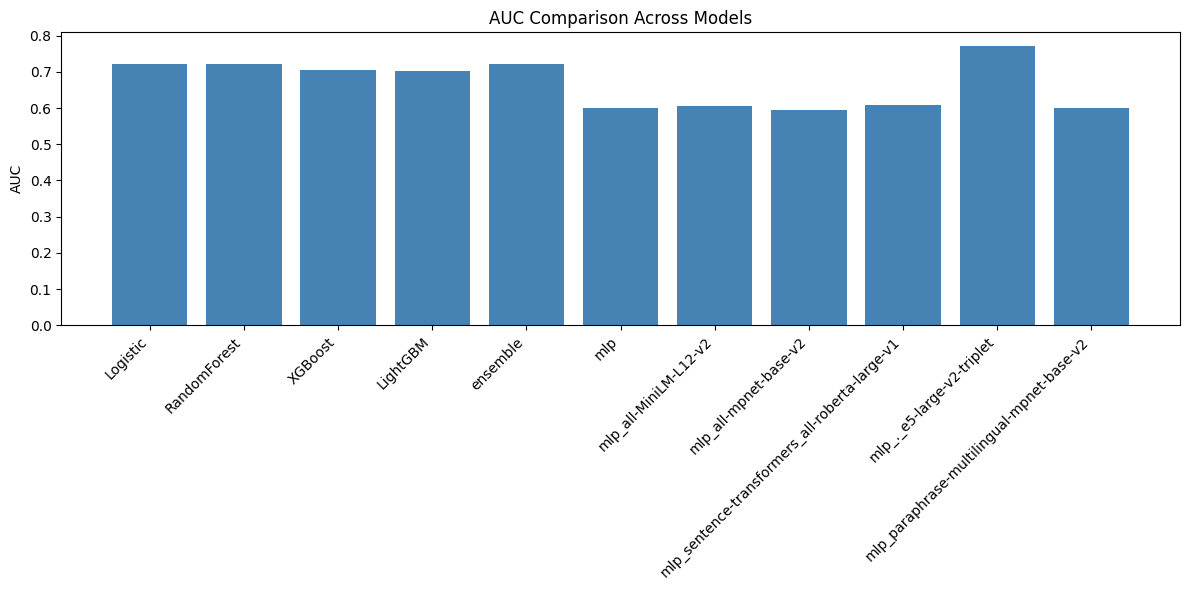

In [68]:
plot_multi_bar(metrics_df, "AUC", title="AUC Comparison Across Models")

In [71]:
def plot_precision_by_rule(all_models_df, rule_col="rule_short", top_n=12, figsize=(14, 6)):

    df = all_models_df.copy()

    if "pred_label" not in df.columns:
        df["pred_label"] = (df["prediction"] >= 0.5).astype(int)

    df["TP"] = ((df["pred_label"] == 1) & (df["rule_violation"] == 1)).astype(int)
    df["FP"] = ((df["pred_label"] == 1) & (df["rule_violation"] == 0)).astype(int)

    top_rules = (
        df[rule_col]
        .value_counts()
        .head(top_n)
        .index
    )

    df = df[df[rule_col].isin(top_rules)]

    precision_table = (
        df.groupby([rule_col, "model_name"])
          .apply(lambda g: (
              g["TP"].sum() / (g["TP"].sum() + g["FP"].sum())
              if (g["TP"].sum() + g["FP"].sum()) > 0 else np.nan
          ))
          .reset_index(name="precision")
    )

   
    precision_matrix = precision_table.pivot(
        index=rule_col,
        columns="model_name",
        values="precision"
    )


    precision_matrix.plot(kind="bar", figsize=figsize)
    plt.title("Precision by Rule Across Models")
    plt.ylabel("Precision")
    plt.xlabel("Rule")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3284/2188358486.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


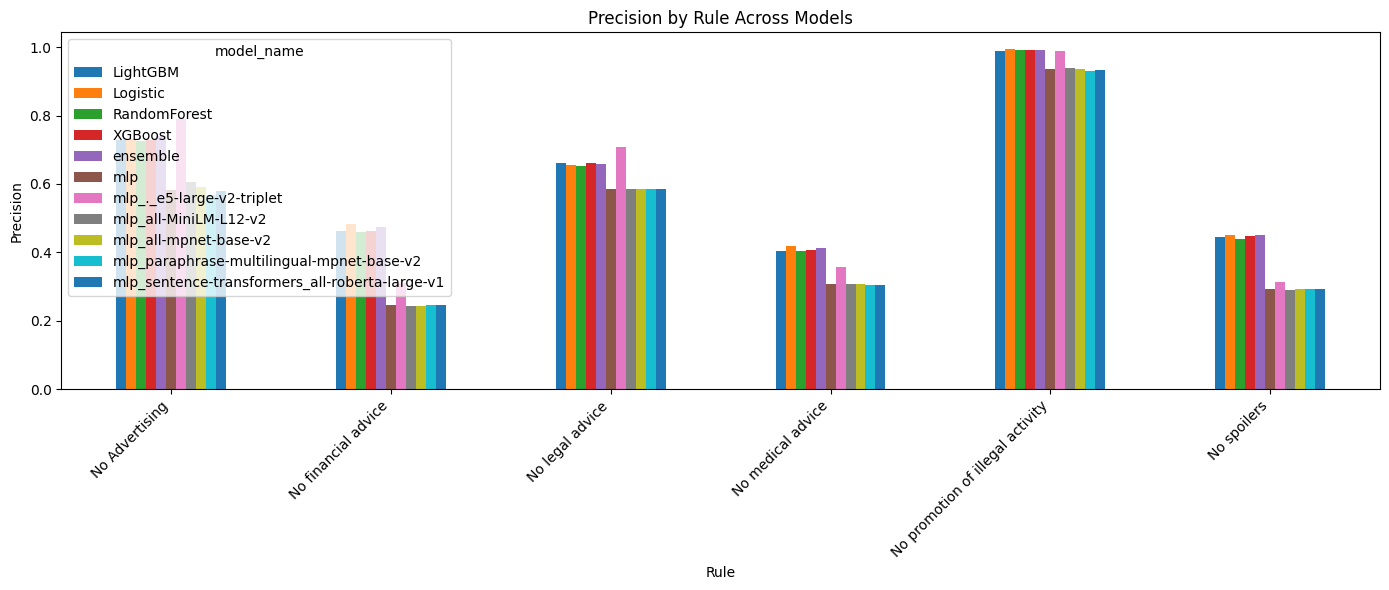

In [72]:
plot_precision_by_rule(all_models_df, top_n=12)

In [64]:

def plot_wrong_prob_kde(df, figsize=(10, 6)):
 
    data = df.copy()
    if "pred_label" not in data.columns:
        data["pred_label"] = (data["prediction"] >= 0.5).astype(int)

    if "error" not in data.columns:
        data["error"] = (data["pred_label"] != data["rule_violation"]).astype(int)

    plt.figure(figsize=figsize)

    for model in data["model_name"].unique():
        sub = data[data["model_name"] == model]

        wrong_probs = sub.loc[sub.error == 1, "prediction"].values

        if len(wrong_probs) > 2:  # KDE requires >2 points
            kde = gaussian_kde(wrong_probs)
            x = np.linspace(0, 1, 200)
            plt.plot(x, kde(x), label=model)

    plt.title("Density of Incorrect Prediction Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()


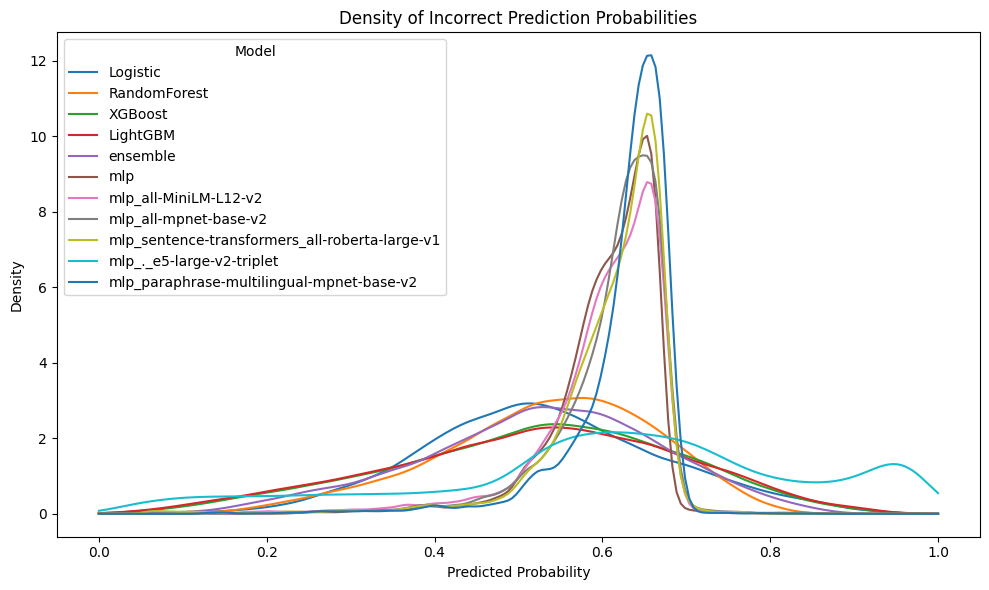

In [65]:
plot_wrong_prob_kde(all_models_df)